In [1]:
import pyshark
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import nest_asyncio
nest_asyncio.apply()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
ATTACK_START = 20
ATTACK_END = 120
PCAP_FILE = "flood.pcap"

In [3]:
ATTACK_START = 20
ATTACK_END = 120
PCAP_FILE = "floodRect.pcap"

In [7]:
def parse_pcap(file_path):
    connections = defaultdict(lambda: {'start_time': None, 'fin_ack_time': None, 'end_time': None})
    cap = pyshark.FileCapture(file_path, display_filter="tcp.port==8080")
    
    for pkt in cap:
        try:
            src_ip = pkt.ip.src
            dst_ip = pkt.ip.dst
            src_port = int(pkt.tcp.srcport)
            dst_port = int(pkt.tcp.dstport)
            timestamp = float(pkt.sniff_timestamp)
            flags = int(pkt.tcp.flags, 16)
            
            conn_tuple = (src_ip, dst_ip, src_port, dst_port)
            reverse_tuple = (dst_ip, src_ip, dst_port, src_port)
            
            # Initialize start_time with the first SYN
            if flags == 0x0002:  # SYN only
                if connections[conn_tuple]['start_time'] is None:
                    connections[conn_tuple]['start_time'] = timestamp
            
            # Record FIN-ACK (potential end from either direction)
            elif flags == 0x0011:  # FIN-ACK
                if connections[conn_tuple]['start_time'] is not None and connections[conn_tuple]['fin_ack_time'] is None:
                    connections[conn_tuple]['fin_ack_time'] = timestamp
                elif connections[reverse_tuple]['start_time'] is not None and connections[reverse_tuple]['fin_ack_time'] is None:
                    connections[reverse_tuple]['fin_ack_time'] = timestamp
            
            # Record final ACK (after FIN-ACK) from either direction
            elif flags == 0x0010:  # ACK
                if (connections[conn_tuple]['fin_ack_time'] is not None and 
                    connections[conn_tuple]['end_time'] is None):
                    connections[conn_tuple]['end_time'] = timestamp
                elif (connections[reverse_tuple]['fin_ack_time'] is not None and 
                      connections[reverse_tuple]['end_time'] is None):
                    connections[reverse_tuple]['end_time'] = timestamp
            
            # Record RST (abrupt end) from either direction
            elif flags & 0x0004:  # RST flag
                if (connections[conn_tuple]['start_time'] is not None and 
                    connections[conn_tuple]['end_time'] is None):
                    connections[conn_tuple]['end_time'] = timestamp
                elif (connections[reverse_tuple]['start_time'] is not None and 
                      connections[reverse_tuple]['end_time'] is None):
                    connections[reverse_tuple]['end_time'] = timestamp
        
        except AttributeError:
            continue  # Skip non-TCP packets
    
    cap.close()
    return connections

def calculate_durations_and_stats(connections):
    durations = []
    start_times = []
    stats = {'non_attack': {'durations': [], 'count': 0, 'completed': 0},
             'attack': {'durations': [], 'count': 0, 'completed': 0}}
    first_timestamp = min(conn['start_time'] for conn in connections.values() if conn['start_time'] is not None)
    
    for conn, details in connections.items():
        if details['start_time'] is not None:
            start_time = details['start_time'] - first_timestamp
            if details['end_time'] is not None:
                duration = details['end_time'] - details['start_time']
            else:
                duration = 100.0  # Default for incomplete connections
            
            durations.append(duration)
            start_times.append(start_time)
            
            # Categorize by attack phase
            if ATTACK_START <= start_time <= ATTACK_END + 3:
                stats['attack']['durations'].append(duration)
                stats['attack']['count'] += 1
                if duration < 100.0:
                    stats['attack']['completed'] += 1
            else:
                stats['non_attack']['durations'].append(duration)
                stats['non_attack']['count'] += 1
                if duration < 100.0:
                    stats['non_attack']['completed'] += 1
    
    return start_times, durations, stats

def print_statistics(stats):
    print("\nConnection Statistics:")
    for phase in ['non_attack', 'attack']:
        durations = stats[phase]['durations']
        if durations:
            avg_duration = np.mean(durations)
            median_duration = np.median(durations)
            max_duration = np.max(durations)
            min_duration = np.min(durations)
            completed_pct = (stats[phase]['completed'] / stats[phase]['count'] * 100) if stats[phase]['count'] > 0 else 0
            
            print(f"\n{phase.capitalize()} Phase (t=0-{ATTACK_START}s and t={ATTACK_END}s-140s if non_attack, t={ATTACK_START}s-{ATTACK_END}s if attack):")
            print(f"  Total Connections: {stats[phase]['count']}")
            print(f"  Completed Connections: {stats[phase]['completed']} ({completed_pct:.6f}%)")
            print(f"  Average Duration: {avg_duration:.6f} seconds")
            print(f"  Median Duration: {median_duration:.6f} seconds")
            print(f"  Max Duration: {max_duration:.6f} seconds")
            print(f"  Min Duration: {min_duration:.6f} seconds")
            if phase == 'attack' and max_duration > 2.0:  # Highlight long durations
                print(f"  Note: {stats[phase]['completed']} legitimate connections completed with unusually long durations (e.g., >2s)")

def plot_durations(start_times, durations):
    plt.figure(figsize=(12, 6))
    plt.scatter(start_times, durations, alpha=0.5, label="TCP Connections")
    
    # Mark attack start and end
    plt.axvline(x=ATTACK_START, color='r', linestyle='--', label=f"Attack Start ({ATTACK_START}s)")
    plt.axvline(x=ATTACK_END, color='g', linestyle='--', label=f"Attack End ({ATTACK_END}s)")
    
    plt.xlabel("Connection Start Time (seconds)")
    plt.ylabel("Connection Duration (seconds)")
    plt.title("TCP Connection Durations vs. Start Time (SYN Attack Mitigated)")
    plt.legend()
    plt.grid(True)
    # plt.yscale('symlog')
    plt.savefig("connection_durations1.png", dpi=300)
    plt.show()

In [5]:
print("Processing PCAP file...")
connections = parse_pcap(PCAP_FILE)
start_times, durations, stats = calculate_durations_and_stats(connections)
print(f"Processed {len(start_times)} TCP connections")

Processing PCAP file...
Processed 92440 TCP connections



Connection Statistics:

Non_attack Phase (t=0-20s and t=120s-140s if non_attack, t=20s-120s if attack):
  Total Connections: 26
  Completed Connections: 26 (100.000000%)
  Average Duration: 0.007229 seconds
  Median Duration: 0.007032 seconds
  Max Duration: 0.016973 seconds
  Min Duration: 0.002502 seconds

Attack Phase (t=0-20s and t=120s-140s if non_attack, t=20s-120s if attack):
  Total Connections: 92414
  Completed Connections: 68 (0.073582%)
  Average Duration: 99.926420 seconds
  Median Duration: 100.000000 seconds
  Max Duration: 100.000000 seconds
  Min Duration: 0.001201 seconds
  Note: 68 legitimate connections completed with unusually long durations (e.g., >2s)


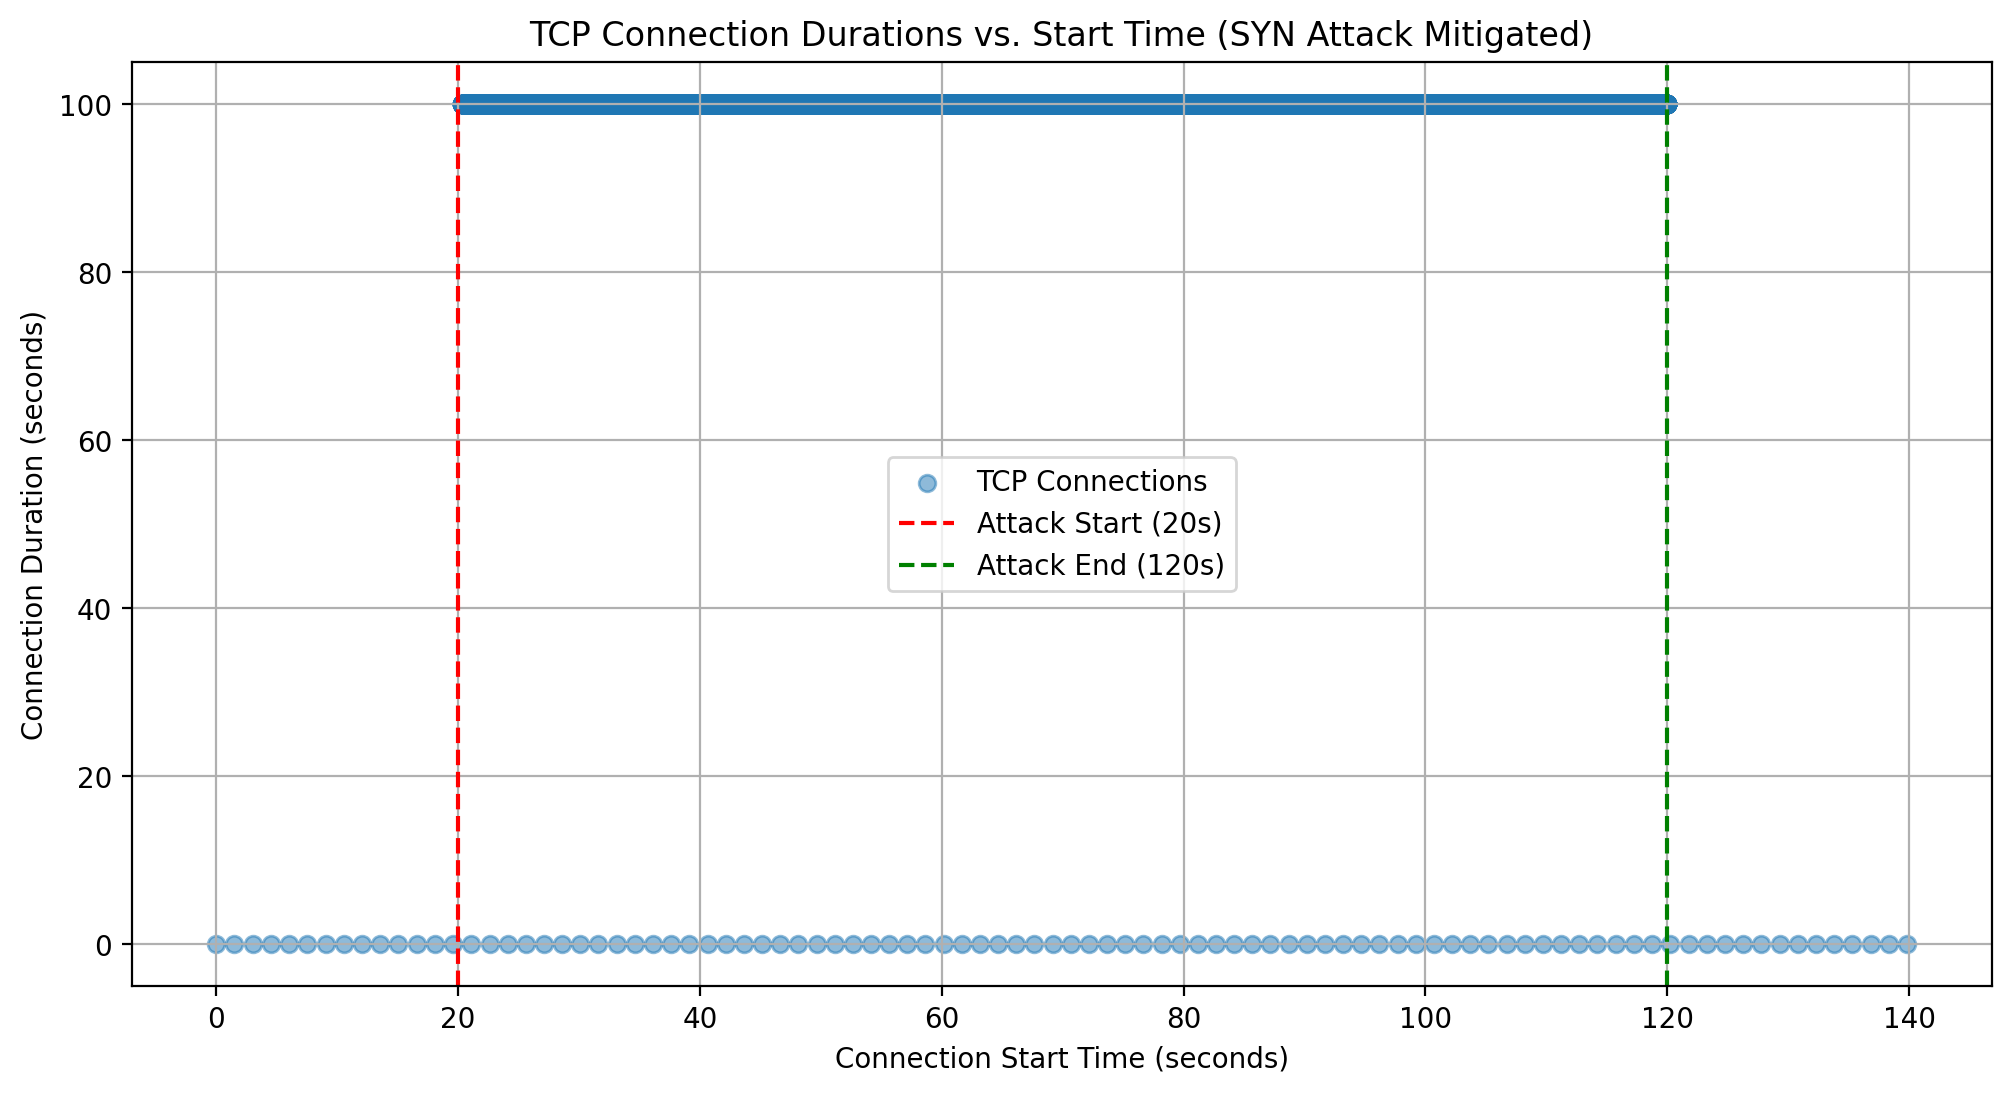

In [8]:
print_statistics(stats)
plot_durations(start_times, durations)

In [9]:
connections

defaultdict(<function __main__.parse_pcap.<locals>.<lambda>()>,
            {('192.168.64.2',
              '192.168.64.3',
              46428,
              8080): {'start_time': 1741546054.376098, 'fin_ack_time': 1741546054.377894, 'end_time': 1741546054.379221},
             ('192.168.64.3',
              '192.168.64.2',
              8080,
              46428): {'start_time': None, 'fin_ack_time': None, 'end_time': None},
             ('192.168.64.2',
              '192.168.64.3',
              46438,
              8080): {'start_time': 1741546055.880526, 'fin_ack_time': 1741546055.886047, 'end_time': 1741546055.887394},
             ('192.168.64.3',
              '192.168.64.2',
              8080,
              46438): {'start_time': None, 'fin_ack_time': None, 'end_time': None},
             ('192.168.64.2',
              '192.168.64.3',
              46454,
              8080): {'start_time': 1741546057.389615, 'fin_ack_time': 1741546057.396359, 'end_time': 1741546057.397333},

In [13]:
cap = pyshark.FileCapture("flood.pcap", display_filter="tcp.port==8080")
cap

<FileCapture flood.pcap>

In [5]:
pkt = cap[0]
pkt

<TCP Packet>

In [11]:
print(pkt)

Packet (Length: 66)
Layer ETH
:	Destination: a2:df:a3:3a:7b:53
	.... ..1. .... .... .... .... = LG bit: Locally administered address (this is NOT the factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Source: b6:e1:34:73:6f:67
	.... ..1. .... .... .... .... = LG bit: Locally administered address (this is NOT the factory default)
	.... ...0 .... .... .... .... = IG bit: Individual address (unicast)
	Type: IPv4 (0x0800)
	Stream index: 1
Layer IP
:	0100 .... = Version: 4
	.... 0101 = Header Length: 20 bytes (5)
	Differentiated Services Field: 0x00 (DSCP: CS0, ECN: Not-ECT)
	0000 00.. = Differentiated Services Codepoint: Default (0)
	.... ..00 = Explicit Congestion Notification: Not ECN-Capable Transport (0)
	Total Length: 52
	Identification: 0x0000 (0)
	010. .... = Flags: 0x2, Don't fragment
	0... .... = Reserved bit: Not set
	.1.. .... = Don't fragment: Set
	..0. .... = More fragments: Not set
	...0 0000 0000 0000 = Fragment Offset: 0
	Time to Live: 6

In [17]:
def give_details(pkt):
    src_ip = pkt.ip.src
    dst_ip = pkt.ip.dst
    flags = pkt.tcp.flags
    src_port = int(pkt.tcp.srcport)
    dst_port = int(pkt.tcp.dstport)
    timestamp = float(pkt.sniff_timestamp)
    print(src_ip, dst_ip, src_port, dst_port, flags, timestamp)

In [20]:
give_details(cap[0])
give_details(cap[1])
give_details(cap[2])
give_details(cap[3])
give_details(cap[4])
give_details(cap[5])
give_details(cap[6])
give_details(cap[7])

192.168.64.2 192.168.64.3 46428 8080 0x0002 1741546054.376098
192.168.64.3 192.168.64.2 8080 46428 0x0012 1741546054.376651
192.168.64.2 192.168.64.3 46428 8080 0x0010 1741546054.377008
192.168.64.3 192.168.64.2 8080 46428 0x0011 1741546054.377894
192.168.64.2 192.168.64.3 46428 8080 0x0010 1741546054.379221
192.168.64.2 192.168.64.3 46428 8080 0x0011 1741546055.377783
192.168.64.3 192.168.64.2 8080 46428 0x0010 1741546055.38094
192.168.64.2 192.168.64.3 46438 8080 0x0002 1741546055.880526
